In [151]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import LpLoss_energy
from models import FNO_reparam

device = 'cpu'

In [152]:
# Subsampling rate
sampling_rate = 3
ntrain = 1500
ntest = 150
batch_size = 32

t1 = 0
t2 = 3
data = np.load("data/ks_1d_data.npy").astype(np.float32)

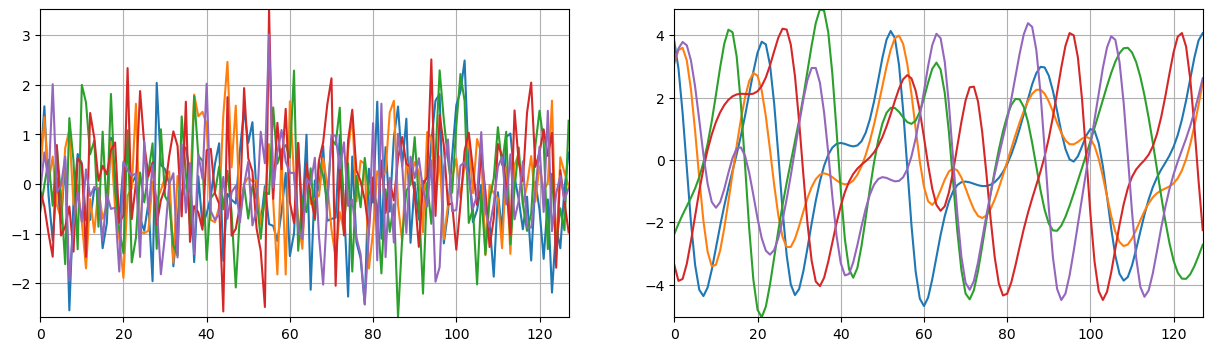

In [153]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
index = 0
for i in n_samples:
    axs[0].plot(data[i, t1])
    axs[1].plot(data[i, t2])


axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [154]:
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain], y_data[:ntrain]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx = gridx.reshape(1, 1, size_x)

x_train = torch.cat((x_train, gridx.repeat([ntrain, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx.repeat([ntest, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

In [155]:
model = FNO(n_modes=(16,), hidden_channels=32, projection_channels=64,
             in_channels = 2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 89121 parameters.


In [156]:
l2loss = LpLoss(d=2, p=2)

eval_losses={'l2': l2loss}

# Training parameters
epochs = 20
learning_rate = 0.001
step_size = 50   # weight-decay step size
gamma = 0.5      # weight-decay rate

optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [157]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-1.6256, Train-MSE-0.8378, Train-L2-0.0286, Test-L2-0.0268
Epoch-1, Time-1.5075, Train-MSE-0.4838, Train-L2-0.0216, Test-L2-0.0185
Epoch-2, Time-1.0006, Train-MSE-0.2291, Train-L2-0.0149, Test-L2-0.0142
Epoch-3, Time-1.5206, Train-MSE-0.1446, Train-L2-0.0119, Test-L2-0.0120
Epoch-4, Time-3.7321, Train-MSE-0.1060, Train-L2-0.0102, Test-L2-0.0110
Epoch-5, Time-2.0665, Train-MSE-0.0824, Train-L2-0.0090, Test-L2-0.0097
Epoch-6, Time-2.9804, Train-MSE-0.0676, Train-L2-0.0081, Test-L2-0.0089
Epoch-7, Time-2.4087, Train-MSE-0.0576, Train-L2-0.0075, Test-L2-0.0085
Epoch-8, Time-2.7194, Train-MSE-0.0522, Train-L2-0.0071, Test-L2-0.0081
Epoch-9, Time-5.7056, Train-MSE-0.0448, Train-L2-0.0066, Test-L2-0.0077
Epoch-10, Time-2.1967, Train-MSE-0.0393, Train-L2-0.0062, Test-L2-0.0071
Epoch-11, Time-2.0108, Train-MSE-0.0357, Train-L2-0.0059, Test-L2-0.0070
Epoch-12, Time-1.5097, Train-MSE-0.0323, Train-L2-0.0056, Test-L2-0.0067
Epoch-13, Time-1.2266, Train-MSE-0.0292, Train-L2-0.0053, Tes

In [158]:
# %%
""" Prediction """
pred = []
test_e = []
with torch.no_grad():
    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y= sample["y"].to(device)
        test_l2 = 0 

        out = model(x)
        test_l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        test_e.append( test_l2/batch_size )
        pred.append( out )
        print("Batch-{}, Test-loss-{:0.6f}".format( index, test_l2/batch_size ))
        index += 1

pred = torch.cat((pred))
test_e = torch.tensor((test_e))  
print('Mean Error:', 100*torch.mean(test_e).numpy())

Batch-0, Test-loss-0.005910
Batch-1, Test-loss-0.005228
Batch-2, Test-loss-0.005167
Batch-3, Test-loss-0.005794
Batch-4, Test-loss-0.004775
Mean Error: 0.5374872591346502


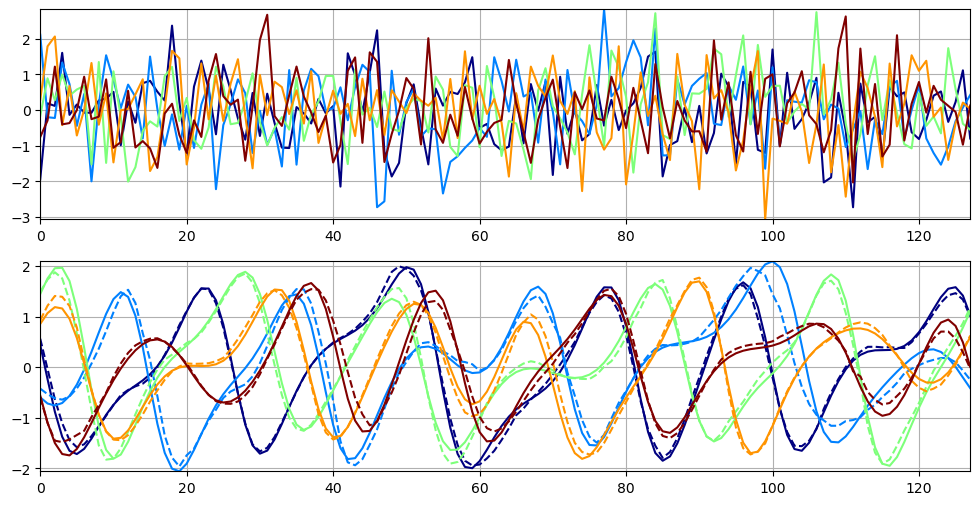

In [159]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 30 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

# PFNO

In [160]:
class WrapGenMultipleSimulations(nn.Module):
    """"""

    def __init__(self, net: nn.Module, n_samples: int = 3):
        """
        Args:
            net (nn.Module): net to wrap
            n_samples (int): number of simulations from the generator per parameter value. Default
                                is 3.
        """
        super(WrapGenMultipleSimulations, self).__init__()
        self.net = net
        self.n_samples = n_samples

    def forward(self, _input, n_samples: int = None):
        """
        Forward pass through the network self.n_samples times

        Args:
            _input: torch Tensor input to the network

        Returns:
            Outputs of the network, stacked along the second dimension and adding a last dimension if missing.
            Shape is therefore [batch, n_samples, out_size].
        """

        if n_samples is None:
            n_samples = self.n_samples

        outputs = [self.net(_input) for i in range(n_samples)]

        # stack along the second dimension and add a last dimension if missing.
        return torch.atleast_3d(torch.stack(outputs, dim=-1))

In [161]:
# Training parameters
epochs = 20


In [162]:
#model = FNO(n_modes=(16,), hidden_channels=32, projection_channels=64,
#             in_channels = 2, use_mlp = True, mlp_dropout = 0.8)
#sample_model = WrapGenMultipleSimulations(model, n_samples=10).to(device)

In [163]:
sample_model = FNO_reparam(n_modes=(16,), hidden_channels=32, projection_channels=64, in_channels=2, n_samples = 5)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
# Loss function
energy_score = LpLoss_energy()

In [164]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-2.5846, Train-L2-0.0532, Test-L2-0.0484
Epoch-1, Time-2.9141, Train-L2-0.0408, Test-L2-0.0370
Epoch-2, Time-3.4441, Train-L2-0.0292, Test-L2-0.0264
Epoch-3, Time-6.5760, Train-L2-0.0224, Test-L2-0.0220
Epoch-4, Time-2.0445, Train-L2-0.0188, Test-L2-0.0191
Epoch-5, Time-3.0983, Train-L2-0.0161, Test-L2-0.0164
Epoch-6, Time-2.7841, Train-L2-0.0143, Test-L2-0.0160
Epoch-7, Time-2.4872, Train-L2-0.0131, Test-L2-0.0140
Epoch-8, Time-2.1253, Train-L2-0.0120, Test-L2-0.0132
Epoch-9, Time-2.0407, Train-L2-0.0114, Test-L2-0.0121
Epoch-10, Time-2.4213, Train-L2-0.0106, Test-L2-0.0117
Epoch-11, Time-2.0831, Train-L2-0.0101, Test-L2-0.0111
Epoch-12, Time-2.2354, Train-L2-0.0095, Test-L2-0.0108
Epoch-13, Time-2.2250, Train-L2-0.0091, Test-L2-0.0109
Epoch-14, Time-2.4717, Train-L2-0.0089, Test-L2-0.0103
Epoch-15, Time-2.4951, Train-L2-0.0084, Test-L2-0.0101
Epoch-16, Time-2.2702, Train-L2-0.0083, Test-L2-0.0098
Epoch-17, Time-2.2693, Train-L2-0.0079, Test-L2-0.0095
Epoch-18, Time-2.238

In [165]:
# %%
""" Prediction """
pred = []
test_e = []
with torch.no_grad():
    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y= sample["y"].to(device)
        test_l2 = 0 

        out = sample_model(x, n_samples = 500)
        test_l2 = l2loss(out.mean(axis = -1).view(batch_size, -1), y.view(batch_size, -1)).item()

        test_e.append( test_l2/batch_size )
        pred.append( out )
        print("Batch-{}, Test-loss-{:0.6f}".format( index, test_l2/batch_size ))
        index += 1

pred = torch.cat((pred))
test_e = torch.tensor((test_e))  
print('Mean Error:', 100*torch.mean(test_e).numpy())

Batch-0, Test-loss-0.005498
Batch-1, Test-loss-0.005400
Batch-2, Test-loss-0.005227
Batch-3, Test-loss-0.005436
Batch-4, Test-loss-0.004953
Mean Error: 0.5302844103425741


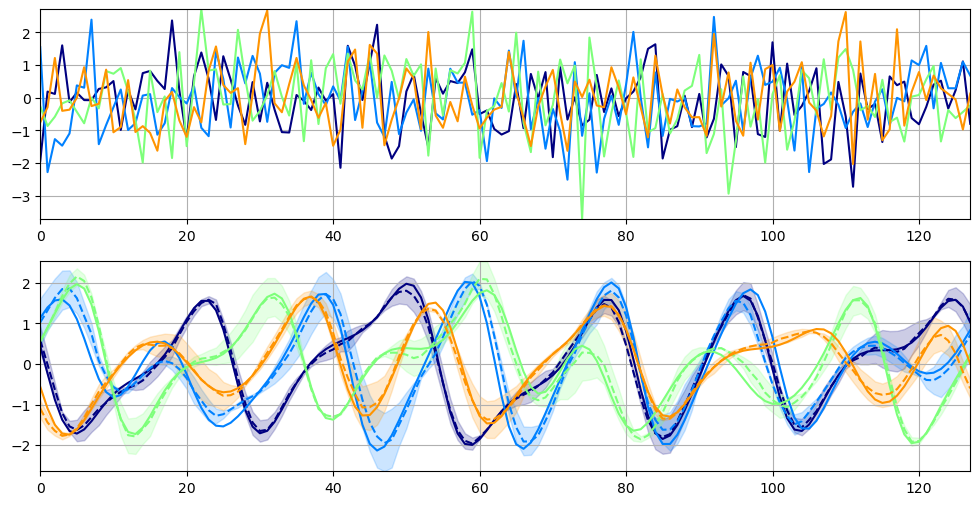

In [166]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)